In [3]:
import scipy.interpolate
import matplotlib.pyplot as plt
import numpy as np 

## Two point multivariate Gaussian

Here we just show that the difference between the train and test point (when there is one of each) grows more slowly than the standard deviation expectation, for Gaussian Processes. 

In [4]:
nr = 1000
r = (0.5 + np.arange(nr)) / np.float32(nr)
f1 = 1.
m2 = r * f1
s2 = (1. - r**2)

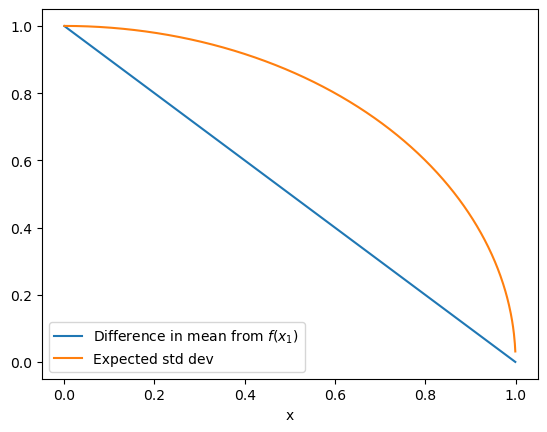

In [5]:
plt.plot(r, 1. - m2, label='Difference in mean from $f(x_1)$')
plt.plot(r, np.sqrt(s2), label='Expected std dev')
plt.xlabel('x')
plt.legend()

## Many point Gaussian Process

In [61]:
def wavy_function(x):
    y = np.sin(x) + (- 2. + 0.9 * x + 0.3 * x**2 - 0.05 * x**3)
    return(y)

In [62]:
nplot = 200
xmin = -4.
xmax = 4.
xplot = xmin + (xmax - xmin) * (np.arange(nplot, dtype=np.float32) + 0.5) / np.float32(nplot)
yplot = wavy_function(xplot)

Text(0, 0.5, 'y')

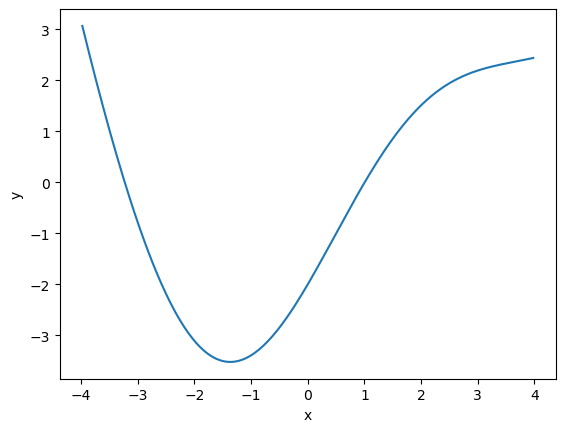

In [63]:
plt.plot(xplot, yplot)
plt.xlabel('x')
plt.ylabel('y')

In [64]:
noise = 0.5 
np.random.seed(11)
ntrain = 50
xtrain = xmin + (xmax - xmin) * np.random.random(size=ntrain)
ytrain = wavy_function(xtrain) + noise * np.random.normal(size=ntrain)

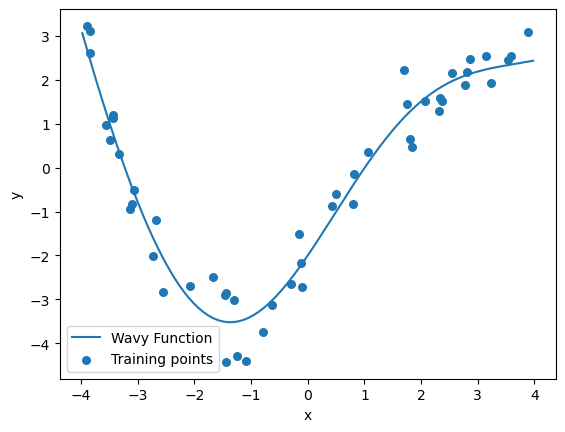

In [65]:
wavy_interp = scipy.interpolate.interp1d(xtrain, ytrain, kind='cubic', fill_value='extrapolate')
yinterp = wavy_interp(xplot)
plt.plot(xplot, yplot, label='Wavy Function')
plt.scatter(xtrain, ytrain, label='Training points', s=30)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

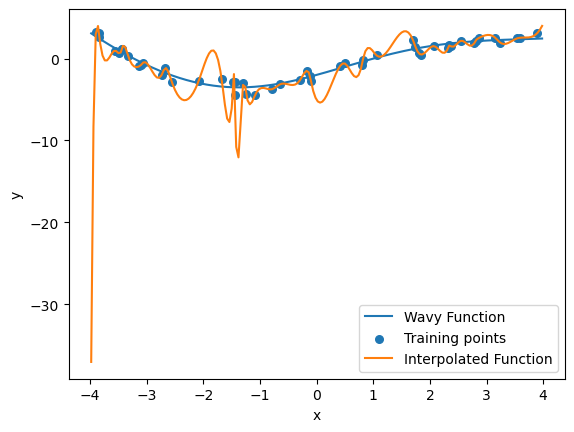

In [66]:
wavy_interp = scipy.interpolate.interp1d(xtrain, ytrain, kind='cubic', fill_value='extrapolate')
yinterp = wavy_interp(xplot)
plt.plot(xplot, yplot, label='Wavy Function')
plt.scatter(xtrain, ytrain, label='Training points', s=30)
plt.plot(xplot, yinterp, label='Interpolated Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [69]:
npoly = 7
A = np.zeros((ntrain, npoly), dtype=np.float32)
for i in np.arange(npoly, dtype=np.int32):
    A[:, i] = xtrain**i

U, w, VT = np.linalg.svd(A, full_matrices=False)

winv = np.float32(w > 0.) / (w + np.float32(w <= 0.))

coeffs = (VT.T).dot(np.diag(winv)).dot(U.T).dot(ytrain)

ypoly = np.zeros(len(xplot), dtype=np.float32)
for i in np.arange(npoly, dtype=np.int32):
    ypoly += coeffs[i] * xplot**i

In [70]:
coeffs, resid, rank, sing = np.linalg.lstsq(A, ytrain, rcond=None)

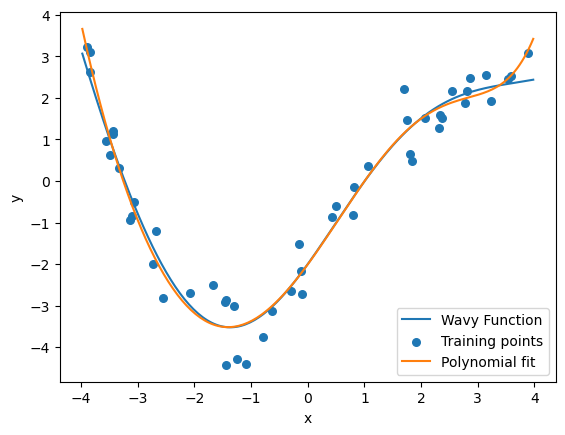

In [71]:
wavy_interp = scipy.interpolate.interp1d(xtrain, ytrain, kind='cubic', fill_value='extrapolate')
plt.plot(xplot, yplot, label='Wavy Function')
plt.scatter(xtrain, ytrain, label='Training points', s=30)
plt.plot(xplot, ypoly, label='Polynomial fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [91]:
def kernel(x, xp, scale=0.5):
    xm = np.outer(x, np.ones(len(xp), dtype=np.float64))
    xpm = np.outer(np.ones(len(x), dtype=np.float64), xp)
    K = np.exp(- 0.5 * (xm - xpm)**2 / scale**2)
    return(K)

In [92]:
xtest = xplot.copy()
Kxx = kernel(xtrain, xtrain)
Ksx = kernel(xtest, xtrain)
Kxs = kernel(xtrain, xtest)
Kss = kernel(xtest, xtest)

In [93]:
sigerr = 0.e-10
sigerr = noise 
Kxx = Kxx + sigerr**2 * np.identity(len(xtrain))
Kxx_inv = np.linalg.inv(Kxx)

In [94]:
L = scipy.linalg.cholesky(Kxx) 

In [95]:
ytest_mean = Ksx.dot(Kxx_inv).dot(ytrain)

In [96]:
ytest_covar = Kss - Ksx.dot(Kxx_inv).dot(Kxs)

In [97]:
ytest_stdev = np.sqrt(np.diag(ytest_covar))

In [98]:
L = np.linalg.cholesky(Kxx)
r, resid, rank, sing = np.linalg.lstsq(L, ytrain, rcond=None)
q, resid, rank, sing = np.linalg.lstsq(L.T, r, rcond=None)
ytest_mean = Ksx.dot(q)

In [99]:
V, resid, rank, sing = np.linalg.lstsq(L, Kxs, rcond=None)
ytest_covar = Kss - V.T.dot(V)

In [100]:
ytest_stdev = np.sqrt(np.diag(ytest_covar))

In [101]:
q, resid, rank, sing = np.linalg.lstsq(Kxx, ytrain, rcond=None)
ytest_mean = Ksx.dot(q)

In [102]:
KxxinvKxs, resid, rank, sing = np.linalg.lstsq(Kxx, Kxs, rcond=1.e-10)
ytest_covar = Kss - Ksx.dot(KxxinvKxs)

In [103]:
ytest_stdev = np.sqrt(np.diag(ytest_covar))

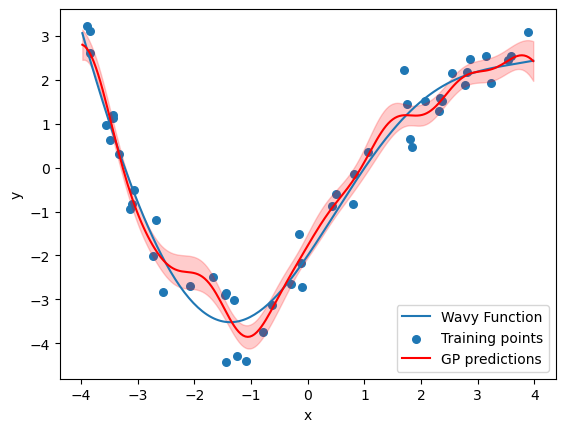

In [104]:
wavy_interp = scipy.interpolate.interp1d(xtrain, ytrain, kind='cubic', fill_value='extrapolate')
plt.plot(xplot, yplot, label='Wavy Function')
plt.scatter(xtrain, ytrain, label='Training points', s=30)
plt.fill_between(xtest, ytest_mean - ytest_stdev,
                 ytest_mean + ytest_stdev, color='red',
                 alpha=0.2)
plt.plot(xtest, ytest_mean, color='red', label='GP predictions')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [105]:
fr = np.random.multivariate_normal(ytest_mean, ytest_covar, size=100)

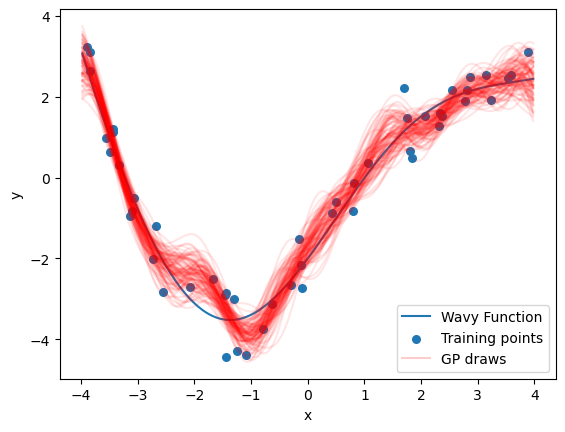

In [106]:
wavy_interp = scipy.interpolate.interp1d(xtrain, ytrain, kind='cubic', fill_value='extrapolate')
plt.plot(xplot, yplot, label='Wavy Function')
plt.scatter(xtrain, ytrain, label='Training points', s=30)
plt.plot([], [], color='red', alpha=0.2, label='GP draws')
for i in np.arange(fr.shape[0]):
    plt.plot(xtest, fr[i, :], color='red', alpha=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [15]:
def kernel(x, xp, scale=2.0):
    xm = np.outer(x, np.ones(len(xp), dtype=np.float64))
    xpm = np.outer(np.ones(len(x), dtype=np.float64), xp)
    K = np.exp(- 0.5 * (xm - xpm)**2 / scale**2)
    return(K)

In [57]:
scales = np.linspace(np.log10(0.5), np.log10(3.), 50)
noises = np.linspace(np.log10(0.5), np.log10(3.), 50)

marglike = np.zeros((len(scales), len(noises)), dtype=np.float32)
for i, scale in enumerate(scales):
    for j, noise in enumerate(noises):
        xtest = xplot.copy()
        Kxx = kernel(xtrain, xtrain, scale=scale)
        Ksx = kernel(xtest, xtrain, scale=scale)
        Kxs = kernel(xtrain, xtest, scale=scale)
        Kss = kernel(xtest, xtest, scale=scale)
        
        sigerr = noise 
        Kxx = Kxx + sigerr**2 * np.identity(len(xtrain))
        Kxx_inv = np.linalg.inv(Kxx)

        chi2 = - 0.5 * ytrain.T.dot(Kxx_inv.dot(ytrain))
        logd, sign = np.linalg.slogdet(Kxx)
        norm = (- 0.5 * logd
                - 0.5 * np.float32(len(ytrain)) * np.log(2. * np.pi))
        marglike[i, j] = chi2 + norm

-119.06849
-123.52918
-128.71326
-134.79494
-142.00493
-150.65422
-161.17076
-174.15738
-190.48692
-211.46448
-239.11803
-276.7498
-330.05862
-409.63443
-537.1621
-763.3383
-1231.7506
-2496.472
-8637.603
-2165145.8
-7413.494
-2312.5432
-1172.4006
-736.87506
-522.9923
-401.10422
-324.49188
-272.89758
-236.33116
-209.3769
-188.8787
-172.8895
-160.15164
-149.82143
-141.3146
-134.21555
-128.22157
-123.10779
-118.70414
-114.87994
-111.5334
-108.584236
-105.968376
-103.63421
-101.53974
-99.65054
-97.938156
-96.37888
-94.95286
-93.643364
-119.56831
-123.90754
-128.93956
-134.82976
-141.7968
-150.13512
-160.24937
-172.7091
-188.33833
-208.36887
-234.71516
-270.49695
-321.10345
-396.55588
-517.3512
-731.15424
-1171.3049
-2342.088
-7920.3135
-1830018.8
-6808.6084
-2173.1038
-1115.7543
-706.17487
-503.93652
-388.471
-315.8219
-266.83688
-232.06245
-206.37752
-186.80067
-171.49394
-159.27026
-149.33308
-141.13042
-134.26917
-128.46275
-123.49801
-119.21346
-115.4849
-112.21541
-109.32843
-106.7628

-129.00403
-127.96895
-126.94974
-125.944405
-145.20674
-146.67056
-148.23824
-149.93929
-151.81314
-153.91315
-156.31242
-159.113
-162.45995
-166.56364
-171.73639
-178.4528
-187.45117
-199.90181
-217.66753
-243.60315
-281.38663
-332.66266
-386.73575
-410.76447
-382.57138
-327.7064
-277.4841
-240.8873
-215.81686
-198.62004
-186.5374
-177.78014
-171.22519
-166.16318
-162.13715
-158.84584
-156.08583
-153.71663
-151.63924
-149.78256
-148.09473
-146.53731
-145.0815
-143.70546
-142.39249
-141.1297
-139.90712
-138.71698
-137.55324
-136.41115
-135.28702
-134.17798
-133.08183
-131.99684
-155.28484
-156.68336
-158.11743
-159.5934
-161.11823
-162.69933
-164.3441
-166.05919
-167.84944
-169.71611
-171.65465
-173.65147
-175.68042
-177.6989
-179.6451
-181.43774
-182.9803
-184.17104
-184.91858
-185.15948
-184.87224
-184.08241
-182.85661
-181.28783
-179.47787
-177.52228
-175.50067
-173.47311
-171.4806
-169.54803
-167.68803
-165.90456
-164.1959
-162.55707
-160.98123
-159.46101
-157.98903
-156.55835
-15

-109.658585
-107.85255
-106.19986
-104.68006
-103.27606
-101.97348
-100.76017
-121.64781
-125.353966
-129.6143
-134.55956
-140.36269
-147.25673
-155.56194
-165.72868
-178.40694
-194.56348
-215.68806
-244.17616
-284.08783
-342.7849
-434.88217
-593.3722
-908.78503
-1726.1788
-5691.797
-1215859.5
-4891.322
-1608.5859
-869.4859
-575.0961
-424.75882
-336.54068
-279.94305
-241.27246
-213.56702
-192.96126
-177.16269
-164.73975
-154.76025
-146.59569
-139.8095
-134.09058
-129.21214
-125.00556
-121.343216
-118.12693
-115.28013
-112.742294
-110.465034
-108.40924
-106.54301
-104.84006
-103.278595
-101.8404
-100.51014
-99.27482
-121.06003
-124.94153
-129.41208
-134.6104
-140.71992
-147.98793
-156.75462
-167.49944
-180.91652
-198.04312
-220.48705
-250.85199
-293.58496
-356.8082
-456.72653
-629.9342
-976.28284
-1873.1913
-6208.463
-1300421.8
-5331.42
-1744.3564
-933.0982
-609.90985
-445.70895
-350.0631
-289.13702
-247.75174
-218.2308
-196.34323
-179.5989
-166.4537
-155.90794
-147.29063
-140.13716
-13

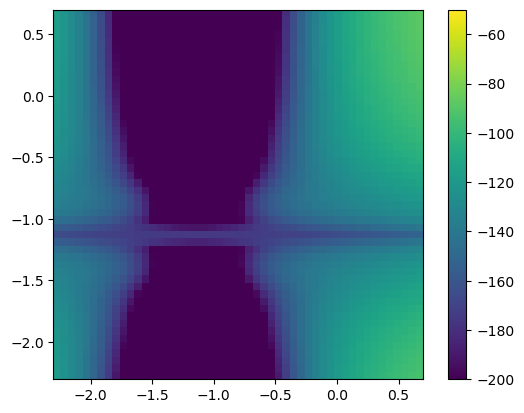

In [60]:
plt.imshow(marglike, origin='lower', vmin=-200., vmax=-50., 
           extent=[np.log(0.1), np.log10(5.), np.log(0.1), np.log10(5)])
plt.colorbar()